# FGV Summer Program 2025
## Recommender Systems class 3 - Data visualization and Content-based RecSys
Diego Galeano, Ph.D.


$\color{green}{\text{Before starting}}$ let's run the following cell to have all the required libraries for this notebook.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import random
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
#import pdb   #This library is used for debugging the code, otherwise it is not necessary.
              #You can simply enter pdb.set_trace() somewhere in your code for debugging purposes.

# If you want to have direct access to the datasets and codes you can clone the following github repository
! git clone https://github.com/saminehbagheri/Recommender-System.git
%cd Recommender-System


Cloning into 'Recommender-System'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66 (from 1)
Receiving objects: 100% (66/66), 347.53 KiB | 2.83 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/Recommender-System


## Content-Based Recommender System

One of the most straight-forward approaches to find a suitable recommendation for users of a platform is the *Content-Based Recommender System* approach. This method determines a rating value $R_{ij}$ for a specific user $u_i$ giving to a specific item $o_j$ by using a feature vector $\vec{x}_i$ for the $i$-th user and a feature vector for the $j$-th item $\vec{\theta}_j$. We try to explain the idea of this approach in the [next section](#CBRS) with a very small example. The biggest problem with such algorithms is that we require to know the important features which have impact on the decisions each user make. It is really difficult to find such set of features. Even if we can define a reasonably good set of important features, the next big challenge is to rate this features for every single item and user. Such information is often not available or not practical to extract fully. Although many platforms have access to some information about the users might be used as features like age, gender etc, often these information are not enough to build good enough feature vectors.


Let's imagine a tiny problem where we only have three users: Samineh, Markus and Peter. If we assume that the only important features for these users (of course in a very simplified scenario) are how much a movie is (1)romantic, (2) comedy  or (3) action, then we can assume a feature vector of size 3 for each user. $\vec{x}_i=\{interest~in~romance, interest~in~comdey, interest~in~action\}$.

We had the chance to ask all of our three users to let us know about their interests by filling their feature vectors. They could have rated each element with 0 if they don't have any interest, 1 if they really care about that feature and 0.5 if their feeling is somewhere in between.

Samineh just likes romance movies and dislikes action and comedy a lot so her feature matrix look like: $\vec{x_s}=[1,0,0]$. Markus likes comedy movies and is not into romance and action at all $\vec{x_m}=[0,1,0]$. Peter dislikes romance but loves action and doesn't mind if there is a sense of humor in the movies so his feature vector looks like: $\vec{x_p}=[0,0.5,1]$. Stacking all these feature vectors together makes the user feature matrix.  

In [ ]:
USER=pd.DataFrame([( [1, 0, 0]), ( [0, 1, 0]), ( [0, 0.5, 1])],
                  columns=['Samineh','Markus','Peter'],
                  index=['Romantic','Comedy','Action']);
print(USER)

          Samineh  Markus  Peter
Romantic        1     0.0      0
Comedy          0     1.0      0
Action          0     0.5      1


We have three movies in our system Titanic, Terminator and Home Alone and we want to figure out what is the best recommendation for each user. In order to do that we need to define a feature vector for each movie. We ask some expert to do that for us. Titanic is a very romantic movie and not funny or action at all so its fair if we rate its feature vector as $\vec{\theta}_{Titanic}=[1,0,0]$. Terminator is an action movie with very little essence of romance and comedy, so our movie expert filled the Terminator's feature vector as $\vec{\theta}_{Terminator}=[0.2,0.1,1]$. The home alone is a comedy movie $\vec{\theta}_{Home-alone}=[0.0,1,0.2]$. Stacking all of the movie features together will give a movie feature matrix.

In [ ]:
ITEM=pd.DataFrame([( [1, 0, 0]), ( [0.2, 0.1, 1]), ( [0, 1, 0.2])],
                  columns=['Titanic','Terminator','Home Alone'],
                  index=['Romantic','Comedy','Action']);
print(ITEM)

          Titanic  Terminator  Home Alone
Romantic      1.0         0.0         0.0
Comedy        0.2         0.1         1.0
Action        0.0         1.0         0.2


The dot product of the $i$-th user feature vector $\vec{x}_i$ and the $j$-th movie feature $\vec{x}_j$ provides a sort of similarity measure. The larger the dot product $\vec{x_i}\cdot\vec{\theta_j}=R_{ij}$ is the likelier that the user $i$ is going to like the movie $j$. We can determine all the similarity measures for each user and item simply by multiplying the user feature matrix and the movie feature matrix, as follows:

In [ ]:
print(ITEM.T.dot(USER))

            Samineh  Markus  Peter
Titanic         1.0     0.2    0.0
Terminator      0.0     0.6    1.0
Home Alone      0.0     1.1    0.2


So according to this simple system we can recommend Titanic to Samineh. To Markus we might recommend Home Alone first and as a second choice Terminator. Th best recommendation for Peter is the Terminator.

I think it is already pretty clear that the main problem with the content-based recommnder systems is the missing information about the feature vectors. First of all it is  very complicated to consider all the important features explicitly. Moreover, it is almost impossible to weight all the features for all users and all items. [Matrix Factorization](#MF) tries to learn these feature matrices by using the exisitng ratings of users.  

# Real-World Datasets
How do the real-world datasets (for recommender systems) often look like? The most common available sort of the data for  recommender systems are user's rating. The item-user rating matrix often is a huge but sparse matrix.
The dataset that we use in this blog-post is a movie-user rating dataset.

We start with loading the data.
We use a dataset with 943 users and 1682 movies. The dataset is provided in mat format. In this mat file there are two matrices. Matrix Y and R.

Y: contains the rating values. Each cell of this matrix can have integer values between 0 to 5. The cells with 0 are actually the unknowns. So, the cell $R_{ij}$=0 means the $i$-th user didn't give any rating for the $j$-th movie. The cells with any value between 1 to 5 are rated by users. Higher ratings represent higher interests.

R: a matrix having 0 or 1. This matrix has 0 values in the unknown cells and 1 for the cells where a rating is provided.

In [ ]:
mat = scipy.io.loadmat('ex8_movies.mat')
movie_names = pd.read_csv('movie_ids.txt',delimiter=';',header=None)[1]
Y=mat['Y']
R=mat['R']
num_user=Y.shape[1]
num_movie=Y.shape[0]
overallRating=np.sum(np.where(Y==1,1,0))
print("number of users:"+str(num_user))
print("number of movies:"+str(num_movie))
print("The overall number of ratings done is: "+str(overallRating))
print("Only "+str(100*overallRating/(num_user*num_movie))+"%  of the matrix is filled")

number of users:943
number of movies:1682
The overall number of ratings done is: 6110
Only 0.3852152981541189%  of the matrix is filled


Let's take a look at the rating distribution. The following cell plotsd the frequency of the ratings in a bar-chart.

<BarContainer object of 6 artists>

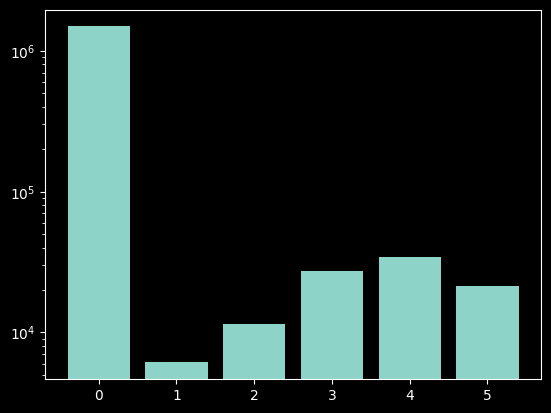

In [ ]:
def howManyR(x):
    return np.sum(np.where(Y==x,1,0))

ratingFrequency=list(map(lambda x:np.sum(np.where(Y==x,1,0)), [0,1, 2, 3, 4,5]))
plt.style.use(['dark_background'])
plt.bar([0,1,2,3,4,5], ratingFrequency,log=True)

As we can see on the plot most of the elements of the rating matrix are zeros meaning that the rating matrix is very sparse. So most of the users did not rate most of the movies. The distribution of ratings is skewed to the right side meaning that there more good ratings and bad ones.

([], [])

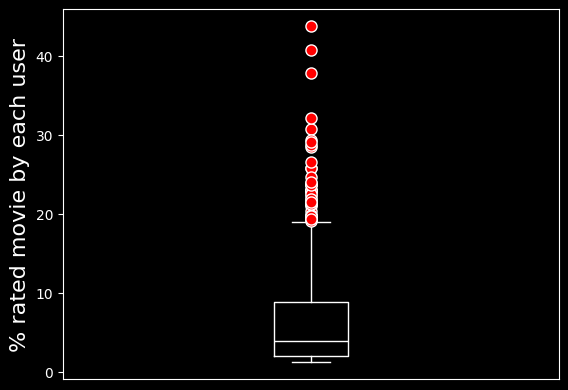

In [ ]:
ratingPercentage=100*np.sum(R,axis=0)/Y.shape[0]
flierprops = dict(marker='o', markerfacecolor='r', markersize=8,
                  linestyle='none', markeredgecolor='w')
bp=plt.boxplot(ratingPercentage
               ,boxprops=dict(linewidth=1.0, color='white')
               ,whiskerprops=dict(linewidth=1.0, color='white')
               ,capprops=dict(linewidth=1.0, color='white')
               ,medianprops=dict(linewidth=1.0, color='white')
               ,flierprops=flierprops)
plt.ylabel('% rated movie by each user', fontsize=16)
plt.xticks([])

In the above plot we can see that most of the users rated less than 10 percent of the movies, although there are very few users who rated up to 40 percent of the movies.


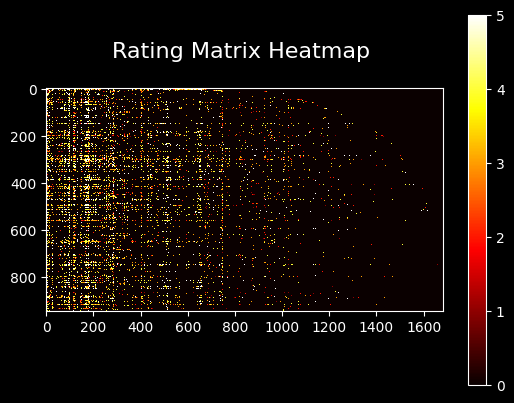

In [ ]:
plt.imshow(Y.T, cmap='hot', interpolation='none')
plt.colorbar()
plt.title('Rating Matrix Heatmap \n', fontsize=16)
plt.show()

The heatmap plot shows the sparsness of the rating matrix clearly.